<a href="https://colab.research.google.com/github/gauthamarcot/nasa_gw_as/blob/main/GravitationalPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
train_dir = '/content/drive/My Drive/Nasa/data/train/train/'
validation_dir = '/content/drive/My Drive/Nasa/data/validation/validation/'
test_dir = '/content/drive/My Drive/Nasa/data/test/test/'

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)  


In [4]:
df = pd.read_csv("/content/drive/My Drive/Nasa/data/trainingset_v1d1_metadata.csv") 
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Low_Frequency_Lines     447
Extremely_Loud          447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
1400Ripples              81
None_of_the_Above        81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

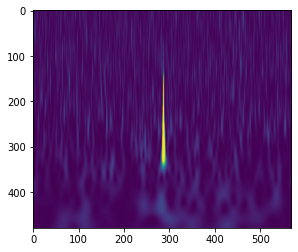

In [5]:
fullpath = train_dir + 'Blip/' + os.listdir(train_dir + 'Blip')[0]
img=mpimg.imread(fullpath)
plt.imshow(img)


In [6]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)

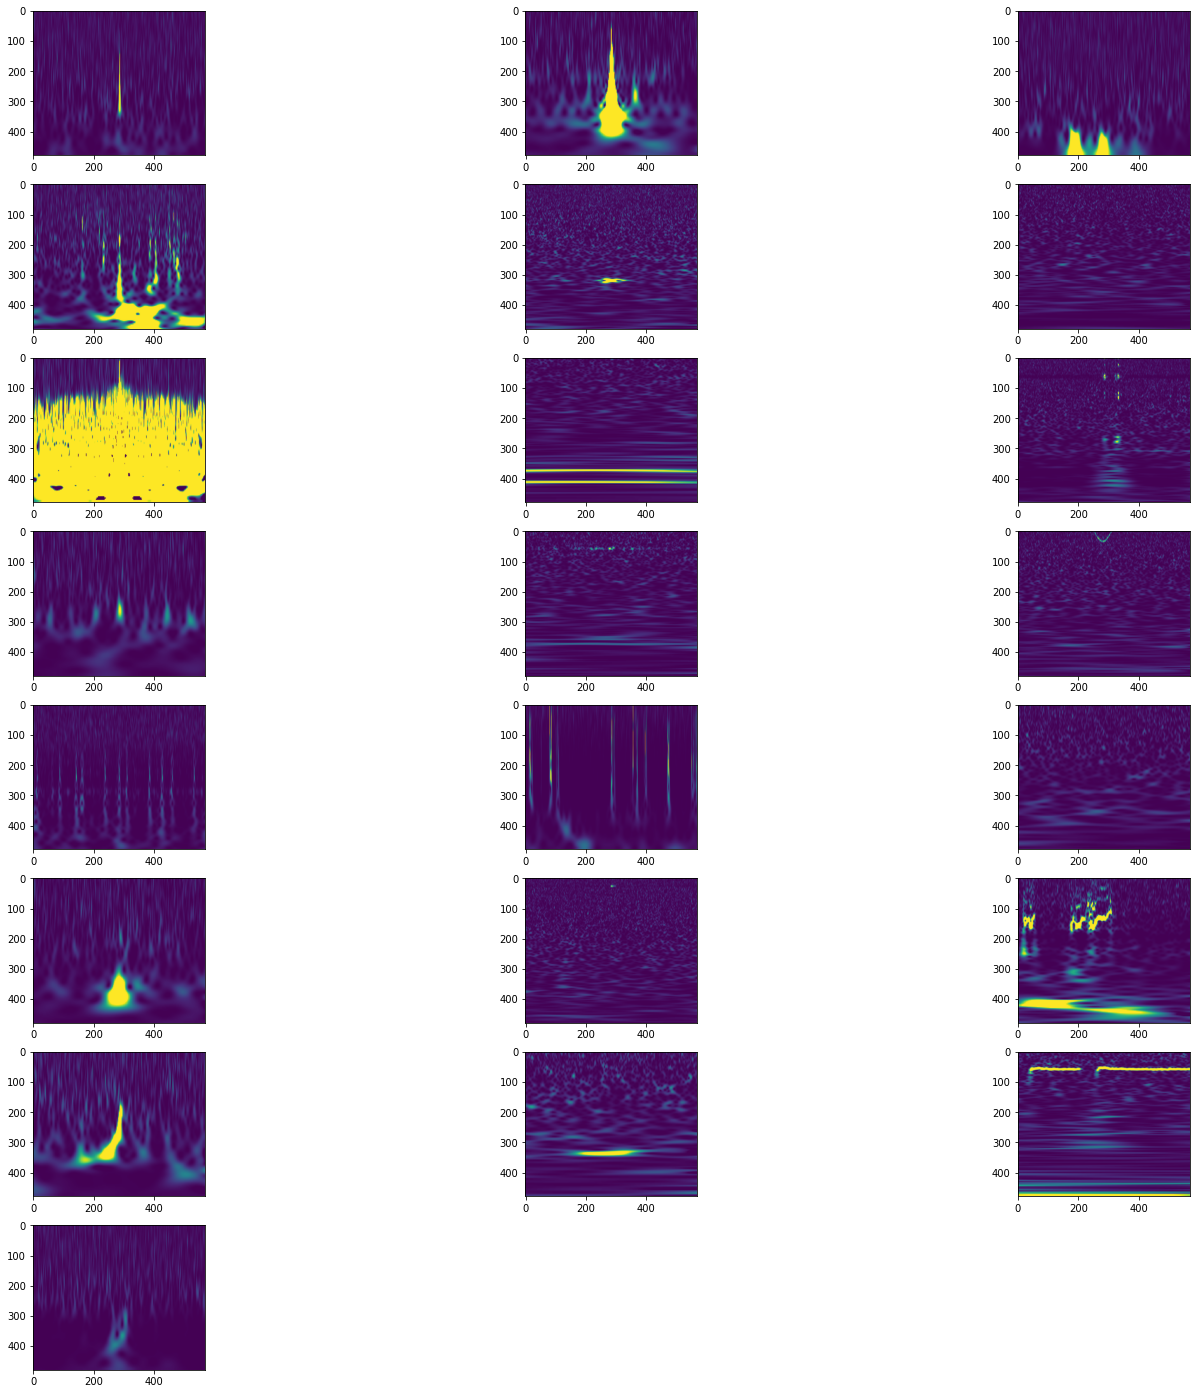

In [7]:
plt.figure(figsize=(25, 25))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + classes_list[i] + '/' + os.listdir(train_dir + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)


In [8]:
training_batch_size = 64
validation_batch_size = 32
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [9]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [10]:
test_size = !find '/content/drive/My Drive/Nasa/data/test/test/' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


In [11]:
input_shape = (img_dim, img_dim, 3)

model = Sequential()
model.add(tf.keras.layers.Conv2D(32, (10, 10), input_shape=input_shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, (5, 5)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(img_dim, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(22, activation="softmax"))


In [ ]:
model.compile(loss = "categorical_crossentropy",  
              optimizer = 'adam', 
              metrics=["accuracy"])

training_step_size = 32
validation_step_size = 32

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 20,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  verbose = 1)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_generator(test_generator, steps = test_size, verbose = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
3028/4720 [==================>...........] - ETA: 25:18

In [ ]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
df['prediction_index'] = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].idxmax(axis=1)

df['prediction'] = ''

for i in range(0,22):
    df['prediction'][df['prediction_index'] == i] = classes_list[i]
    
cm = confusion_matrix(df['truth'], df['prediction'])

cm_df = pd.DataFrame(cm)

cm_df.columns = classes_list
cm_df['signal'] = classes_list

cm_df

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 12))

corr = cm_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(0, 200, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [ ]:
accuracy = accuracy_score(df['truth'], df['prediction'])
accuracy